# TP : Mod√©lisation et r√©solution d'un probl√®me de classification

**Instructions g√©n√©rales:**

- Je vous conseille de r√©aliser ce devoir avec `jupyter lab` et non pas `jupyter notebook`. La raison est que `jupyter notebook` a parfois du mal √† afficher des images. Si vous ne voyez pas d'image de chat en Section **I.0**, c'est qu'il y a un probl√®me.
- Les d√©pendances n√©cessaires sont incluses dans le fichier `requirements.txt`.
- Le devoir vous a √©t√© distribu√© sous la forme d'un dossier contenant un notebook et d'autres fichiers. Vous pouvez d√©placer le dossier o√π vous voulez dans votre ordinateur, mais ne changez pas la structure de ce dossier : le notebook a besoin de ces fichiers auxiliaires pour fonctionner!
- Certaines questions n√©cessitent de faire tourner un algorithme. Je vous recommande de ne pas faire tourner vos algorithmes plus qu'une trentaine de secondes (chez moi tout marche bien en moins d'une seconde).

**Description du devoir:**

- la partie **I** est une mise en bouche avec le probl√®me.
- la partie **II** porte sur un probl√®me-jouet, et est celle o√π vous mettrez en valeur certaines des choses que vous avez appris en cours. Elle se d√©compose en trois sections **ind√©pendantes**, qui proposent de r√©soudre le probl√®me de trois mani√®res diff√©rentes. Elles peuvent √™tre trait√©es √† des moments diff√©rents du cours:
  - la partie **II.A** ne requiert aucune connaissance particuli√®re du cours. Si vous voulez simplement vous amuser avec le sujet c'est par l√†!
  - la partie **II.B** porte sur la dualit√© de Rockafellar (fin du chapitre 2). Elle vous demandera de faire des petits calculs de dualit√© √† la main. C'est l'occasion de voir si vous avez compris les bases de ce chapitre!
  - la partie **II.C** porte sur les m√©thodes d'√©clatement, et n√©c√©ssite d'avoir vu la notion d'op√©rateur proximal (d√©but du chapitre 3).
- la partie **III** est une application √† un probl√®me de traitement de donn√©es, qui consiste √† exploiter les r√©sultats de la partie **II** sur un vrai probl√®me. C'est l√† que vous montrerez si vous avez compris ce qui se passe dans la partie **II**.

In [1]:
# cette cellule importe les modules n√©c√©ssaires √† ce TP. En cas d'erreur, vous devrez au pr√©alable installer les modules manquants.
import numpy
import matplotlib
import scipy
import sklearn

# I. Introduction

## 0. Description g√©n√©rale du probl√®me

On suppose que l'on dispose d'un certain type de donn√©es, et on veut √™tre capable de les **classer** en deux groupes. Ce type de probl√®me peut √™tre tr√®s facile √† r√©aliser pour un humain, mais toute la question est de savoir comment automatiser cette prise de d√©cision pour l'impl√©menter sur une machine.

| Un probl√®me simple de classification simple pour un humain | |
|---|---|
| ![](images/cat.jpg) | ![](images/dog.jpg) |
| Type de donn√©es: photos | Classes possibles : Chat ou chien |

L'objectif de ce TP est de vous montrer comment r√©soudre ce type probl√®me (en tout cas lorsqu'il n'est pas trop difficile). Dans un premier temps vous vous familiariserez avec le sujet sur des donn√©es synth√©tiques, puis vous travaillerez ensuite avec de vraies donn√©es: des photos contenant des caract√®res √©crits √† la main.

**Pr√©sentation du probl√®me**

Une fa√ßon de mod√©liser ce probl√®me est la suivante: on se retrouve face √† une donn√©e $x \in \mathbb{R}^N$ et on veut lui attribuer une classe. Pour simplifier, lorsqu'on a un probl√®me √† deux classes comme dans les exemples ci-dessus, on dit souvent que les deux classes sont $\{-1,+1\}$. 
Par exemple $-1$ pourrait d√©signer "chien" et $1$ d√©signerait "chat".

Ce que l'on souhaite donc impl√©menter est ce que l'on appelle un **classifieur**, c'est-√†-dire une fonction $c : \mathbb{R}^N \longrightarrow \{-1,+1\}$ qui prend en entr√©e une donn√©e $x \in \mathbb{R}^N$, et qui donne en sortie une √©tiquette $\pm 1$. Evidemment on ne va pas prendre n'importe quelle fonction $\mathbb{R}^N \longrightarrow \{-1,+1\}$, on veut que notre calssifieur fasse un "bon" travail en classant les donn√©es qu'on lui fournit.

**Comment faire √ßa?**

En pratique on suit le processus suivant: 

*1) Consititution d'une base de donn√©es*: on se procure

- Une famille de donn√©es $\{x_1, \dots, x_m\} \subset \mathbb{R}^N$ (par exemple tout un tas de photos de chats et de chiens)
- La famille des √©tiquettes correspndantes $\{y_1, \dots, y_m\} \subset \{ -1,+1\}$, o√π chaque $y_i$ a √©t√© bien choisi par un humain

Par exemple, en reprenant la convention ci-dessus, si $x_{47}$ est une photo de chien, alors $y_{47}=-1$ (rappelons que toute photo peut √™tre vue comme un vecteur de $\mathbb{R}^N$ o√π $N$ correspond au nombre de pixels de la photo).

*2) La phase d'entra√Ænement*: √† partir de cette base de donn√©es, on va construire un classifieur $c : \mathbb{R}^N \longrightarrow \{-1,+1\}$, en demandant √† ce que ce classifieur verifie, pour tout point de notre base de donn√©es, $c(x_i) = y_i$. Ainsi, on esp√®re que si le classifieur fonctionne bien sur notre base de donn√©es, alors il fonctionnera √©galement lorsqu'on lui pr√©sentera de nouvelles donn√©es.

Ce TP se focalisera sur cette phase, le but √©tant de montrer que derri√®re ce probl√®me se cache en fait un probl√®me d'optimisation, que l'on va r√©soudre.

*3) La phase de test*: Une fois que l'on aura trouv√© notre classifieur, il faudra bien tester si il marche bien! Pour cela, on se constituera une nouvelle base de donn√©es $\{(\hat x_i,\hat y_i)\}$ similaire √† celle mentionn√©e plus haut, et on regardera si l'√©tiquette pr√©dite $c(\hat x_i)$ est bien √©gale √† $\hat y_i$. On pourra par exemple compter le nombre de fois o√π le classifieur trouve la bonne r√©ponse, et donc en d√©duire un pourcentage de succ√®s estim√©.

**Rq:** Noter qu'en pratique on ne constitue pas deux bases de donn√©es. On construit une grosse base de donn√©es une fois pour toute, puis on la divise en deux parties: les donn√©es dites "d'entrainement" qui vont servir √† construire le classifieur $c$, et d'autre part les donn√©es de "test" qui vont permettre d'√©valuer si notre classifieur marche bien sur de nouvelles donn√©es.



## 1. Premier contact avec le probl√®me

In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

**1)** On commence par importer des donn√©es

In [3]:
X = np.load('data/donnees_entrainement.npy')

Ces donn√©es correspondent √† $m$ points de $\mathbb{R}^2$, qui sont rang√©es dans une matrice √† $m$ lignes et 2 colonnes.
Chaque *ligne* de la matrice correspond donc √† un point de $\mathbb{R}^2$.
Vous pouvez regarder quelle est la taille de la matrice avec la m√©thode `X.shape`, ce qui vous permettra de d√©terminer la valuer de $m$.

In [4]:
X.shape

(200, 2)

In [5]:
m = 200 # √† definir

Vu que nos donn√©es sont des points du plan, on va pouvoir facilement les visualiser avec la fonction `plt.scatter` de pyplot.

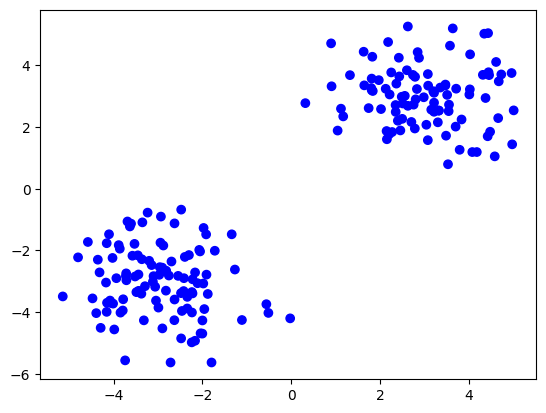

In [6]:
couleur = [None]*m # liste vide de taille m
for k in range(m):
    couleur[k] = 'blue'
_=plt.scatter(X[:, 0], X[:, 1], c=couleur)

**2)** Vous devriez √™tre maintenant convaincus que ce jeu de donn√©es contient deux groupes de points appartenant √† des familles distinctes. Or nous n'en savons rien, √† priori, le seul moyen d'en √™tre sur est d'aller regarder les *etiquettes* correspondantes. Importons-les:

In [7]:
Y = np.load('data/etiquettes_entrainement.npy')

V√©rifiez que ce vecteur ne contient que des √©tiquettes $\pm 1$.

In [8]:
Y

array([ 1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,
       -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.,
       -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,
       -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,
        1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
       -1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
        1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
        1.,  1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1., -1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,
       -1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1., -1.,
       -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,
        1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1

En adaptant le code de la pr√©c√©dente question, affichez de nouveau ce nuage de points cette fois-ci avec deux couleurs: rouge pour les points avec l'√©tiquette $-1$, et bleu pour les points avec l'√©tiquette $+1$.

In [9]:
couleur = [None]*m
for k in range(m):
    if Y[k] == 1:
        couleur[k] = 'blue'
    else:
        couleur[k] = 'red'

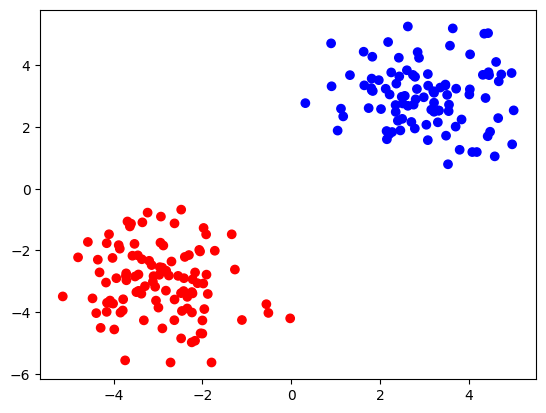

In [10]:
_=plt.scatter(X[:, 0], X[:, 1], c=couleur)

**3)** Une approche intuitive pour classer ce probl√®me consiste √† tracer une droite qui va s√©parer ces deux nuages: ainsi fait, on pourra dire que tout nouveau point qui apparaitra d'un c√¥t√© de la droite sera "rouge" et de l'autre les "bleus".

Ici on va consid√©rer une droite dans $\mathbb{R}^2$ comme √©tant l'ensemble des points satisfaisant l'√©quation

$$ D = \{ x \in \mathbb{R}^2 \ | \ \langle a, x \rangle + b =0 \},$$

o√π $a \in \mathbb{R}^2$ et $b \in \mathbb{R}$ sont √† choisir. On notera par la suite $w = (a_1, a_2 ,b) \in \mathbb{R}^2 \times \mathbb{R}$ le vecteur de param√®tres d√©crivant la droite $D$.

En utilisant le code ci-dessous, ajoutez le trac√© d'une droite aux donn√©es, et jouez avec la valeur de $w$ pour essayer de trouver la droite qui s√©pare le mieux les deux classes.

In [11]:
def trace_droite(w):
    # trace la droite des points x v√©rfiant l'√©quation <a,x>+b=0
    # o√π w = (a_1, a_2, b)
    a = w[0:2]
    b = w[2]
    if a[1] == 0:
        alpha, beta = 0, 0
    else:
        alpha = -a[0]/a[1]
        beta = -b/a[1]
    abscisse = np.arange(-5,5,0.1)
    ordonnee = alpha*abscisse + beta
    plt.plot(abscisse, ordonnee)

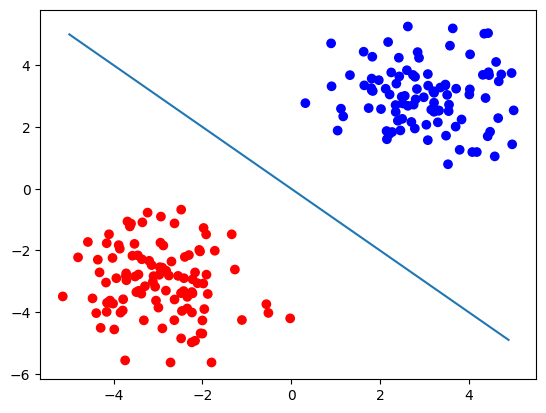

In [12]:
w = np.array([1, 1, 0]) # √† modifier
trace_droite(w)
_=plt.scatter(X[:, 0], X[:, 1], c=couleur)

Pensez-vous que certaines droites sont meilleures que les autres?

## 2. Mod√©lisation : trouver une droite s√©paratrice optimale

Ici nous allons **mod√©liser** le probl√®me : le formaliser sous la forme d'un probl√®me math√©matique, et plus pr√©cis√©ment sous la forme d'un probl√®me d'optimisation.

On cherche √† trouver un bon param√®tre $w = (a,b)\in \mathbb{R}^2 \times \mathbb{R}$, qui va d√©crire une bonne droite d'√©quation $\langle a,x \rangle + b= 0$.
Mais qu'est-ce qu'une *bonne* droite? 

|  | Choisir une bonne droite pour s√©parer les donn√©es | |
|---|---|---|
| ![](images/classif_neutral.png) | ![](images/classif_good.png) | ![](images/classif_bad.png) |
| Un nouveau point appara√Æt | Quelle droite classifie le mieux ? |  |

Au vu de la question pr√©c√©dente, on attend deux propri√©t√©s:

- D'une part on veut clairement que la droite **s√©pare** bien les deux groupes de donn√©es.
- D'autre part, on voudrait que la droite passe le **plus loin possible** des donn√©es. 
  - En effet, si un nouveau point vient √† apparaitre on imagine qu'il va rester pr√®s d'un des deux nuages. Donc si la droite est loin des nuages, elle sera √©galement loin de ce nouveau point, et on √©vitera le probl√®me d'un point qui apparait trop pr√®s de la droite, en qui on n'aurait pas trop confiance.

Nous allons maintenant exprimer ces deux propri√©t√©s.

### a. S√©parer les donn√©es



La droite d'√©quation $\langle a,x \rangle + b= 0$ coupe l'espace en deux demi-espaces: les points qui v√©rifient $\langle a,x \rangle + b \geq  0$ et ceux qui v√©rifient $\langle a,x \rangle + b \leq 0$.
Notre objectif est que chaque nuage (rouge et bleu) soit d'un seul c√¥t√© de la droite. Il faut donc que
- pour toute donn√©e $i$ telle que $y_i = +1$ (les points bleus donc), on ait $\langle a,x_i \rangle + b \geq 0$,
- pour toute donn√©e $i$ telle que $y_i = -1$ (les points rouges donc), on ait $\langle a,x_i \rangle + b \leq 0$.

Autrement dit, on veut que pour toute donn√©e $i$, $\langle a,x_i \rangle + b$ ait le m√™me signe que $y_i$. Ce que l'on peut √©crire de mani√®re √©quivalente:
\begin{equation*}
    (\forall i=1,\dots, m) \quad y_i(\langle a,x_i \rangle + b) \geq 0. \tag{1}
\end{equation*}
La propri√©t√© ci-dessus peut se r√©√©crire comme une in√©galit√© vectorielle $\Phi w \succeq 0$, pourvu qu'on introduise la bonne matrice $\Phi$.
En effet, si on rappelle que $w = (a,b)$ et que l'on d√©finit $\Phi$ par
\begin{equation*}
    \Phi :=
    \begin{pmatrix}
        y_1 x_1^\top & y_1 \\
        \vdots & \vdots \\
        y_i x_i^\top & y_i \\
        \vdots & \vdots \\
        y_m x_m^\top & y_m
    \end{pmatrix} \in \mathcal{M}_{m,3}(\mathbb{R}),
\end{equation*}

on voit que le produit entre la matrice $\Phi$ et le vecteur $w=(a,b)$ vaut


\begin{darray}{rcl}
    & 
    & 
    \begin{pmatrix}
        a \\
        b
    \end{pmatrix}
    \\
    \Phi w = 
    &
    \begin{pmatrix}
        y_1 x_1^\top & y_1 \\
        \vdots & \vdots \\
        y_i x_i^\top & y_i \\
        \vdots & \vdots \\
        y_m x_m^\top & y_m
    \end{pmatrix} 
    & 
    \begin{pmatrix}
        y_1(\langle a,x_1 \rangle + b) \\
        \vdots  \\
        y_i(\langle a,x_i \rangle + b) \\
        \vdots  \\
        y_m(\langle a,x_m \rangle + b)
    \end{pmatrix},
\end{darray}

et donc que la propri√©t√© (1) est √©quivalente √† ce que tous les coefficients de $\Phi w$ soient positifs, autrement dit, √† ce que $\Phi w \succeq 0$. Noter que $\Phi$ ne d√©pend que des donn√©es $x_i,y_i$ !

**En r√©sum√©:** Une droite param√©tr√©e par $w$ s√©pare bien les deux nuages si et seulement si $\Phi w \succeq 0$.




### b. Choisir la droite la plus √©loign√©e des donn√©es

Supposons que l'on aie une droite $D_w$ d'√©quation $\langle a,x \rangle + b =0$, param√©tr√©e par $w =(a,b)$.
Etant donn√©e une donn√©e quelconque $x_i$, la distance entre cette donn√©e $x_i$ et la droite $D_w$ se note ${\rm{dist}}~(x_i;D_w)$.
Ainsi, la distance entre la droite $D_w$ et le point qui en est le plus proche est simplement le minimum de ces distances:
$$
\min\limits_{i=1,\dots, m} \ {\rm{dist}}~(x_i;D_w).
$$
En d'autres termes, la quantit√© ci-dessus repr√©sente la distance entre la droite $D_w$ et le nuage de points form√© par les donn√©es.

Puisque notre objectif est de choisir la droite la plus **√©loign√©e** des donn√©es, on veut donc maximiser cette distance aux donn√©es. Autrement dit, on veut trouver le param√®tre $w = (a,b) \in \mathbb{R}^3$ qui maximise cette distance, tout en respectant la contrainte de bien s√©parer les donn√©es (cf. paragraphe pr√©c√©dent):
\begin{equation*}
    {\rm R√©soudre} 
    \quad 
    \max\limits_{w, \ \Phi w \succeq 0} \ \min\limits_{i=1,\dots, m} \ {\rm{dist}}~(x_i;D_w), 
    \quad 
    \text{ o√π } D_w=\{x \in \mathbb{R}^2 \ | \ \langle a,x \rangle + b =0 \}.
\end{equation*}

Ce probl√®me a l'air difficile! Mais il est en fait possible de montrer qu'il est *√©quivalent* (on l'admet ici) √† r√©soudre le probl√®me suivant, qui est un peu plus sympatique:
\begin{equation*}
    {\rm R√©soudre} 
    \quad 
    \min\limits_{w=(a,b) \in \mathbb{R}^2 \times \mathbb{R}} \ \frac{1}{2} \Vert a \Vert^2, 
    \quad 
    \text{ sous la contrainte que } \Phi w \succeq e,
    \tag{P}
\end{equation*}
o√π $e:=(1,\dots,1)^\top \in \mathbb{R}^m$.

**En r√©sum√©:** Pour trouver une droite s√©paratrice optimale, il faut minimiser $\Vert a \Vert^2$ sous la contrainte que $w=(a,b)$ v√©rifie $\Phi w \succeq e$.

### c. Le probl√®me √† r√©soudre : Support Vector Machine (SVM)

Si on extrapole notre probl√®me de s√©parer $m$ points dans $\mathbb{R}^2$ √† la s√©paration de $m$ points dans $\mathbb{R}^n$, alors on se ram√®ne √† r√©soudre le probl√®me d'optimisation quadratique convexe suivant (appel√© SVM) : 
\begin{equation*}
    \min\limits_{w \in \mathbb{R}^{n+1}} \ \frac{1}{2} \Vert Pw \Vert^2, 
    \quad 
    \text{ sous la contrainte que } \Phi w \succeq e,
    \tag{P}
\end{equation*}
o√π 

- $e:=(1,\dots,1)^\top \in \mathbb{R}^m$ 
- $P \in \mathcal{M}_{n+1}(\mathbb{R})$ est la matrice de projection sur $F = \{ w \in \mathbb{R}^{n+1} \ | \ w_{n+1}=0\}$. Autrement dit $P$ projette sur les $n$ premi√®res coordonn√©es, c-√†-d $P= {\rm{diag}}(1, \dots, 1, 0)$.
- $\Phi \in \mathcal{M}_{m,n+1}(\mathbb{R})$ est la matrice d√©finie par

\begin{equation*}
    \Phi :=
    \begin{pmatrix}
        y_1 x_1^\top & y_1 \\
        \vdots & \vdots \\
        y_i x_i^\top & y_i \\
        \vdots & \vdots \\
        y_m x_m^\top & y_m
    \end{pmatrix}.
\end{equation*}

- la solution $w \in \mathbb{R}^{n+1}$ s'√©crit comme un couple $w=(a,b) \in \mathbb{R}^n \times \mathbb{R}$ qui va nous d√©finir un hyperplan s√©parateur $\{x \in \mathbb{R}^n \ | \ \langle a,x \rangle +b = 0 \}$.

# II. R√©solution du probl√®me : phase d'entra√Ænement

Dans cette partie, nous allons r√©soudre le probl√®me (P) de trois mani√®res diff√©rentes, dans les sections A,B et C.
Ces trois sections sont de difficult√© variable, mais ind√©pendantes. Ceci √©tant dit, il est attendu que vous fassiez les trois.

**0)** D√©finir `e`, le vecteur $e:=(1,\dots,1)^\top \in \mathbb{R}^m$, ainsi que `Phi`, la matrice d√©finie dans la section pr√©c√©dente. On rappelle que cette matrice ne d√©pend que de `X` et `Y`.

On d√©finira √©galement `infini`, le vecteur $(+\infty, \dots, +\infty) \in \mathbb{R}^m$, sachant que la quantit√© $+\infty$ s'obtient avec `np.inf`.

In [13]:
e=np.ones(m)

In [14]:
e

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [15]:
Phi = np.zeros((m,3)) # matrice vide
Phi[:, 0:-1] = X # toutes les colonnes sauf une remplies par X
Phi[:, -1] = e # derni√®re colonne remplie par des 1
Phi = np.diag(Y)@Phi # on multiplie chaque ligne par y_i

In [16]:
infini = e*np.inf

## A. R√©solution via un solver Python

Ici nous allons simplement donner le probl√®me √† Python, qui dispose de certaines routines pour r√©soudre les probl√®mes d'optimisation. Toute la difficult√© consiste en la mise en forme du probl√®me dans une syntaxe que Python peut conmprendre.

**1)** D√©finir une fonction `objectif` qui prend en entr√©e un vecteur $w=(a,b) \in \mathbb{R}^n \times \mathbb{R}$ et qui renvoie $\Vert a \Vert^2$.

In [17]:
def objectif(w):
    return np.sum(w**2) - w[-1]**2

**2)** On doit r√©soudre un probl√®me d'optimisation sous contrainte. Pour cela, on va faire appel √† la biblioth√®que `scipy.optimize` qui peut faire cela pour nous. 

In [18]:
from scipy.optimize import LinearConstraint, minimize

Tout d'abord on doit d√©finir la contrainte $\Phi w \succeq e$. Il faut pour cela utiliser la fonction `LinearConstraint` qui permet de d√©finir une contrainte de la forme
$$
\{ w \in \mathbb{R}^d \ | \ a \preceq \Phi w \preceq b \}
$$
avec la commande `LinearConstraint(Phi, a, b)` (voir la [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.LinearConstraint.html#scipy.optimize.LinearConstraint) pour plus de d√©tails). A vous de compl√©ter la commande suivante, avec les objets d√©finis √† la question **1)**.

In [19]:
contrainte = LinearConstraint(Phi, e, infini)

**3)** On peut maintenant obtenir la solution de notre probl√®me, en faisant appel √† `scipy.optimize.minimize` (voir la [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) pour plus de d√©tails).

In [20]:
w_sol_scipy = minimize(                          # minimiser
                    fun = objectif,           # la fonction 'objectif'
                    constraints = contrainte, # sous la contrainte 'contrainte'
                    x0 = np.random.randn(3),  # en partant d'un point initial
                    ).x                       # et donne-moi le vecteur solution
w_sol_scipy

array([ 0.28086697,  0.39547876, -0.03896802])

**4)** Reprendre le code de la partie **I.1**, pour afficher les nuages de points ainsi que la droite d√©finie par le param√®tre $w_{sol-scipy} \in \mathbb{R}^3$ que vous venez d'obtenir. √ätes-vous satisfait(e) de la solution obtenue?

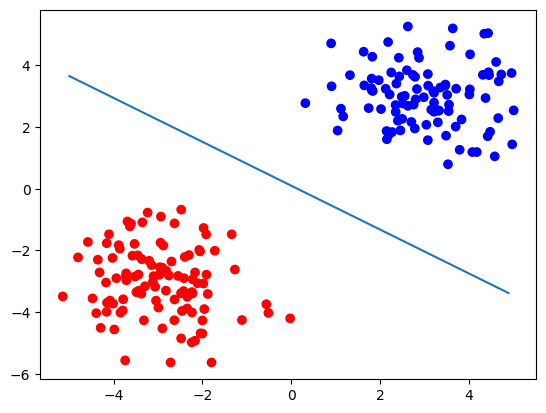

In [21]:
trace_droite(w_sol_scipy)
_=plt.scatter(X[:, 0], X[:, 1], c=couleur)

## B. R√©solution via le probl√®me dual et la m√©thode du gradient projet√©

Ici nous allons nous int√©r√©sser √† (D), le probl√®me dual de (P) au sens de Fenchel-Rockafellar. Dans un premier temps nous allons calculer ce probl√®me dual. Dans un second temps, nous allons voir qu'il a une structure plus simple, le rendant facile √† r√©soudre.
Dans un troisi√®me temps, nous allons r√©soudre (D) avec la m√©thode du gradient projet√©, puis retrouver une solution du probl√®me primal (P).

### 1. Calcul du probl√®me dual

**1)** üìù Montrer que le probl√®me (P) peut s'√©crire sous la forme 
\begin{equation*}
    \min\limits_{w \in \mathbb{R}^{n+1}} \ f(w) + g(\Phi w), 
    \tag{P}
\end{equation*}
o√π
- $f$ est une fonction quadratique semi d√©finie positive,
- $g = \delta_C$ est la fonction indicatrice de $C$, un ensemble convexe ferm√© non vide.

**R√©ponse:** Ici $f(w) = (1/2) \Vert Pw \Vert^2$ et $C = \{ \alpha \in \mathbb{R}^M \ | \ \alpha \succeq e \}$.

**2)** üìù D'apr√®s la dualit√© de Fenchel-Rockafellar, le probl√®me dual de (P) consiste √† r√©soudre
\begin{equation*}
    \min\limits_{u \in \mathbb{R}^m} \ f^* (-\Phi^\top u) + g^* (u), 
    \tag{D}
\end{equation*}
Vous devrez:

- Calculer la conjugu√©e de Fenchel $f^*$. Pour cela vous pourrez utiliser un r√©sultat de la feuille de TD sur la conjugu√©e.
- Calculer la conjugu√©e de Fenchel $g^*$. Vous utiliserez des r√©sultats du cours  pour montrer que 
\begin{equation*}
    g^*(u) = \delta_K(u) - \langle e, u \rangle,
\end{equation*}
o√π $K$ est un c√¥ne convexe ferm√© (tr√®s sympatique) non vide.

**R√©ponse:** 
- Si on pose $F=  \{ u\in \mathbb{R}^{n+1} \ | \ u_{n+1}=0 \}$ alors $f^*(u) = (1/2)\Vert u \Vert^2 + \delta_F(u)$.
Autrement dit, $f^*(u) = (1/2)\Vert u \Vert^2$ si $u_{n+1}=0$, $+\infty$ sinon.
- Ici $g(p)$ est l'indicatrice de $p \succeq e$. Donc $g(p) = \delta_K(p-e)$, o√π $K=\mathbb{R}^m_+$ est l'orthant positif.
Donc $g^* (u) = \delta_K^* (u) + \langle e, u \rangle =\delta_{K^*}(u) + \langle e,u \rangle$, o√π $K^* = \mathbb{R}^m_-$ est l'orthant n√©gatif.

**3)** üìù Conclure que le probl√®me dual s'√©crit

\begin{equation*}
    \min\limits_{u \in \mathbb{R}^M} \ h(u), 
    \quad 
    \text{ sous la contrainte que } u \in K \text{ et } \langle y,u \rangle =0,
    \tag{D}
\end{equation*}
o√π $h$ est une fonction convexe quadratique.

**R√©ponse:** Tout ce qu'on a calcul√© nous donne pour le dual:
$$\frac{1}{2}\Vert -\Phi^\top u \Vert^2 + \langle e,u \rangle + \delta_F(-\Phi^\top u) + \delta_{\mathbb{R}^M_-}(u).
$$
On pose donc $h(u) = \frac{1}{2}\Vert \Phi^\top u \Vert^2 + \langle e,u \rangle$ qui est bien convexe quadratique.
Le terme $\delta_{\mathbb{R}^M_-}(u)$ donne la contrainte $u \in K=\mathbb{R}^m_-$.
Le terme $\delta_F(-\Phi^\top u)$ veut dire que la $n+1$ √®me coordonn√©e de $\Phi^\top u$ doit √™tre nulle. Or d'apr√®s la d√©finition de $\Phi$, la $n+1$ √®me coordonn√©e de $\Phi^\top u$ c'est $\langle y, u \rangle$. D'o√π le r√©sultat.

### 2. D√©finition de la projection



Ici on s'int√©resse √† la projection sur la contrainte duale
$$D:= \{ u \in \mathbb{R}^M \ | \ u \in K \text{ et } \langle y,u \rangle =0\},$$
o√π $K$ est le c√¥ne simple que vous avez obtenu √† la section pr√©c√©dente.

**1)** D√©finir une fonction `proj_K` qui prend en entr√©e un vecteur `u` et renvoie en sortie la projection de $u$ sur $K$.

In [22]:
def proj_K(u):
    return np.minimum(0, u)

**2)** D√©finir une fonction `proj_H` qui prend en entr√©e un vecteur `u` et le vecteur `y` et renvoie en sortie la projection sur l'hyperplan d√©fini par
$$H := \{ u \in \mathbb{R}^M \ | \ \langle y, u \rangle =0 \}.$$
Pour ce faire, vous chercherez (√† la main ou sur internet ou dans le cours qui sait) comment calculer la projection sur un Hyperplan.

In [23]:
def proj_H(u,y):
    return u - (y.T@u)/la.norm(y)**2 * y

**3)** D√©finir une fonction `proj_D_approx` qui 

- prend en entr√©e un vecteur `u` et le vecteur `y`
- renvoie en sortie une approximation de la projection de $u$ sur $D = K \cap H$

Pour calculer cette projection approximative, vous allez utiliser la m√©thode de **projection de Dijkstra** sur une dizaine d'it√©rations.
Elle se d√©finit via des projections altern√©es sur $H$ et $K$, comme suit:

| Projection de Dijkstra |
|-|
| On veut projeter $u$ sur $K\cap H$ |
| On initialise $x_0=u$, et $h_0=p_0=q_0=0$, puis pour $k \geq 0$: | 
| $$\begin{cases} h_{k+1} & =  {\rm{proj}}_H(x_k+p_k) \\ p_{k+1} &= x_k + p_k - h_{k+1} \\ x_{k+1} &= {\rm{proj}}_K( h_{k+1} + q_k) \\ q_{k+1} &= h_{k+1} + q_k - x_{k+1} \end{cases}$$ |
| **Th√©or√®me:** $x_k \to {\rm{proj}}_{K\cap H}(u)$ lorsque $k \to +\infty$ |

In [24]:
def proj_D_approx(u, y):
    # projection altern√©e de Dijkstra sur l'intersection H et K
    # where K is the positive orthant cone
    # and H is the hyperplane of equation <x,y>=0
    x=u #initilisation de x
    n=u.shape # on r√©cup√®re la dimension
    h=np.zeros(n) #initilisation de y
    p=np.zeros(n) #initilisation de p
    q=np.zeros(n) #initilisation de q
    for _ in range(20):
        h = proj_K(x+p)
        p = x + p - h
        x = proj_H(h+q, y)
        q = h + q - x
    return x

**4)** On va ici impl√©menter une alternative √† la m√©thode de projection approch√©e de la question pr√©c√©dente avec la **projection de Kiwiel**. Cette derni√®re s'effectue avec la fonction `proj_kiwiel` (import√©e ci-dessous), qui:

- projette un vecteur $u$ sur une intersection $K \cap H$ 
   - o√π $H$ est un hyperplan $H = \{ u \in \mathbb{R}^M \ | \ \langle y, u \rangle =0 \}$
   - o√π $K$ est un ensemble d√©fini par $K = \{ u \in \mathbb{R}^M \ | \ a \preceq u \preceq b \}$
     - ici les bornes $a, b \in \mathbb{R}^M$ peuvent prendre des valeurs $\pm \infty$
- prend en entr√©e `proj_kiwiel(u, y, a, b)` o√π $u$ est le vecteur √† projeter, $y$ le vecteur d√©finissant l'hyperplan $H$, et $a,b$ sont les bornes (inf√©rieures et sup√©rieures) d√©finissant $K$.
- renvoie en sortie la projection de $u$ sur $K \cap H$.

Votre travail ici consiste √† d√©finir une fonction `proj_D` qui prend en entr√©e un vecteur `u`, le vecteur `y`, et renvoie la projection de $u$ sur $D$.
Pour ce faire, vous d√©finirez les bornes `a` et `b` qui d√©finissent $K$, et vous appliquerez la projection de Kiwiel.

In [25]:
from scripts.kiwiel import proj_kiwiel

In [26]:
def proj_D(u, y):
    dim = u.shape[0]
    b = np.zeros(dim)
    a = -np.ones(dim)*np.inf
    return proj_kiwiel(u, y, a, b)    

**5)** Prendre un vecteur $u \in \mathbb{R}^M$ quelconque, et comparer les projections `proj_D_approx` et `proj_D`. Vous regarderez notamment si le vecteur projet√© v√©rifie bien les contraintes $K \cap H$.

In [27]:
u = np.random.randn(m)

In [28]:
p_dyj = proj_D_approx(u, Y)
p_dyj.T@Y
np.max(p_dyj)
# la contrainte de positivit√© n'est pas parfaitement v√©rifi√©e. Celle d'hyperplan est vraie √† 1e-15 pr√®s

np.float64(2.800682060571935e-08)

In [29]:
p_kiw = proj_D(u, Y)
p_kiw.T@Y
np.max(p_kiw)
# la contrainte de positivit√© est mieux v√©rifi√©e

np.float64(0.0)

### 3. M√©thode du gradient projet√©

La m√©thode du gradient projet√© permet de r√©soudre un probl√®me de la forme 
$$ \min f(x), x \in C$$
L'algorithme s'√©crit 

| | | |
|-|-|-|
|| On choisit $x_0$ un vecteur de $\mathbb{R}^N$ et $\rho > 0$ un pas fixe. | 
|  | Pour $k\geq 0$ : $\qquad \qquad \, $   $x_{k+1}$  = ${\rm{proj}}_C(x_k - \rho \nabla f(x_k))$  | 

L'algorithme est garanti de converger si $f$ est convexe, de classe $C^1$, avec un gradient $L$-Lipschitzien, et un pas $\rho \in ]0,2/L[$.

**1)** üìù V√©rifier que les hypoth√®ses ci-dessus sont v√©rifi√©es pour le probl√®me dual (D). En particulier, vous calculerez $\nabla h$, et vous d√©finirez sa constante de Lipschitz `L`.

In [30]:
# la hessienne de h est la matrice Phi Phi^T donc
L = np.linalg.norm(Phi,2)**2
mu = np.linalg.norm(Phi,-2)**2

In [31]:
L

np.float64(3775.018183700163)

In [32]:
mu

np.float64(199.17419367021907)

**2)** D√©finir une fonction `FB_dual` qui r√©soud le probl√®me dual (D) en:

- prenant en entr√©e la matrice `Phi`, le vecteur `y`, un pas `rho`, un nombre d'it√©rations `nb_iter`
- r√©solvant le probl√®me dual en appliquant la m√©thode du gradient projet√© :
  - en initialisant les it√©r√©s en $0 \in \mathbb{R}^m$
  - avec un pas `rho`
  - en r√©alisant la projection sur $D$ avec une fonction d√©finie dans la section pr√©c√©dente (de votre choix)
  - pendant un nombre d'it√©rations √©gal √† `nb_iter`
- retournant en sortie le dernier it√©r√© calcul√© 

In [33]:
def FB_dual(Phi, y, rho, nb_iter=500):
    N = Phi.shape[1]
    M = Phi.shape[0]
    # y = Phi[:,-1] # la derni√®re colonne
    e = np.ones(M)
    # resolution du pb dual
    u = np.zeros(M)
    for i in np.arange(nb_iter):
        u = u - rho * (Phi @ Phi.T @ u + e)
        u = proj_D(u, y)
    return u

**3)** Trouver `u_sol_GPD` une solution approch√©e au probl√®me dual (D).

In [34]:
rho = 2/(L+mu)
u_sol_GPD = FB_dual(Phi, Y, rho, nb_iter=10000)

In [35]:
u_sol_GPD[-1]

np.float64(0.0)

**4)** üìù D'apr√®s la caract√©risation des solutions du probl√®me primal-dual vu en cours, on sait que la solution $w$ du probl√®me primal est li√©e √† la solution $u$ du probl√®me dual via l'inclusion $w \in \partial f^*(-\Phi^\top u)$.
Montrer que ceci implique que $-\Phi^\top u$ peut s'√©crire   $-\Phi^\top u= (a,0)$ o√π $a \in \mathbb{R}^n$, et que $w=(a,b)$ pour un certain $b$ √† d√©terminer.

**Correction:** 
- On a calcul√© pr√©c√©demment que $f^*(u) = (1/2)\Vert u \Vert^2 + \delta_F(u)$.
Donc $\partial f^*(u) = u + N_F(u)$ si $u \in F$, $\partial f^*(u) = \emptyset$ sinon.
- Le th√©or√®me nous dit que $w \in \partial f^*(-\Phi^\top u)$, donc forc√©ment $\Phi^\top u \in F$. Ceci veut dire que sa derni√®re coordonn√©e est nulle et que $\Phi^\top u = (a,0)$.
- De plus $N_F(u) = F^\bot = \{ (0,b) \ | \ b \in \mathbb{R} \}$.
- donc on a $w = -\Phi^\top u + (0,b), b \in \mathbb{R}$.



**5)** Vous v√©rifierez num√©riquement que la derni√®re coordonn√©e de $\Phi^\top u$ est bien nulle. D√©finissez `a`.

In [36]:
w_sol_GPD = -Phi.T @ u_sol_GPD
w_sol_GPD[-1]

np.float64(0.0)

In [37]:
a = w_sol_GPD[:-1]
a

array([0.28083955, 0.39549777])

**6)** On admet par la suite que l'on peut prendre $b=0$, c-√†-d que $w = -\Phi^\top u$ est solution de notre probl√®me primal (P). Reprendre le code de la partie **I.1**, pour afficher les nuages de points ainsi que la droite d√©finie par le param√®tre $w \in \mathbb{R}^3$ que vous venez d'obtenir. √ätes-vous satisfait(e) de la solution obtenue?

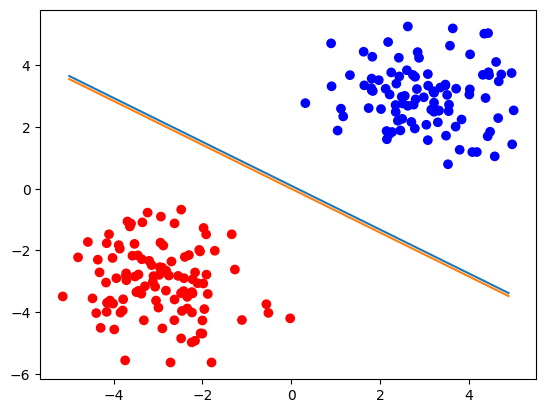

In [38]:
trace_droite(w_sol_scipy)
trace_droite(w_sol_GPD)
_=plt.scatter(X[:, 0], X[:, 1], c=couleur)

## C. R√©solution via une m√©thode d'√©clatement

Dans cette section, l'objectif est que vous soyez plus autonomes. Nous vous fournissons un algorithme, un th√©or√®me, et vous devez vous en servir pour trouver une solution aux probl√®mes (P) et (D). A vous de v√©rifier (et de nous convaincre) que votre code fonctionne et vous fournit une solution satisfaisante.

On introduit l'algorithme de **Loris-Verhoeven**, qui est une g√©n√©ralisation de la m√©thode du gradient proximal, et un cas particulier de l'algorithme de Yan, qui s'applique √† la minimisation d'une fonction de la forme $g(Ax) + h(x)$, o√π $g \in \Gamma_0(\mathbb{R}^M)$ et $h \in \Gamma_0(\mathbb{R}^N) \cap C^{1,1}_L(\mathbb{R}^N)$:

| L'algorithme de **Loris-Verhoeven** |
| --- |
| Soient $x_0 \in \mathbb{R}^N, u \in \mathbb{R}^M$, $\lambda, \sigma >0$ |
| $$\begin{cases} x_{k+1} &= x_k - \lambda \nabla h(x_k) - \lambda A^\top u_n \\ u_{k+1} &=  {\rm prox}_{{\sigma}g^*} \left(u_n + \sigma A \left[2x_{k+1} - x_k + \lambda \nabla h(x_k) - \lambda \nabla h(x_{k+1}) \right]\right) \end{cases}$$ |

**Th√©or√®me:** Soient $h : \mathbb{R}^n \to \mathbb{R}$ une fonction diff√©rentiable √† gradient $L$-Lipschitzien,  $g : \mathbb{R}^m \to \mathbb{R}\cup\{+\infty\}$ une fonction convexe s.c.i. propre, et $A \in \mathcal{M}_{m,n}(\mathbb{R})$.
Soit $(x_k,u_k)_{k \in \mathbb{N}}$ une suite g√©n√©r√©e par l'algorithme de Loris-Verhoeven, avec
$$ \lambda \in \left]0, \frac{2}{L}\right[ \quad \text{ et } \quad \sigma \in \left]0, \frac{1}{\lambda \Vert A \Vert^2}\right].$$
Alors 
- $x_k$ converge vers un minimiseur de $f + g \circ A$, s'il en existe,
- $u_k$ converge vers un minimiseur de $f^* \circ -A^\top + g^*$ s'il en existe.

In [39]:
def grad_h(x):
    # gradient de 0.5*norm(Px) qui vaut Px
    g = x.copy()
    g[-1] = 0
    return g

def proj_C(u):
    # projection sur { x | x >= e }
    e = np.ones(u.shape[0])
    return np.maximum(u, e)

def prox_g_star(u, sigma):
    # prox de sigma g*
    # on applique la formule de d√©composition de Moreau
    return u - sigma*proj_C( u/sigma )

def LV(Phi, y, nb_iter):
    m, n = Phi.shape
    lmbda = 1 # car f est de gradient 1-Lipschitzien
    norm_phi_sq = la.norm(Phi,2)**2
    sigma = 1/norm_phi_sq # car on peut prendre 1/(lmbda*|A|**2)

    x = np.zeros(n)
    u = np.zeros(m)
    
    for _ in range(nb_iter):
        x_old = x
        x = x - lmbda*grad_h(x) - lmbda*Phi.T @ u
        u = prox_g_star( u + sigma*Phi@(2*x - x_old + lmbda*grad_h(x_old) - lmbda*grad_h(x)) , sigma)
    return x, u

In [40]:
w_sol_LV, u_sol_LV = LV(Phi, Y, nb_iter=10000)

In [41]:
la.norm(w_sol_LV - w_sol_GPD)

np.float64(0.03400986036995927)

In [42]:
la.norm( u_sol_LV - u_sol_GPD )

np.float64(0.008898568880840032)

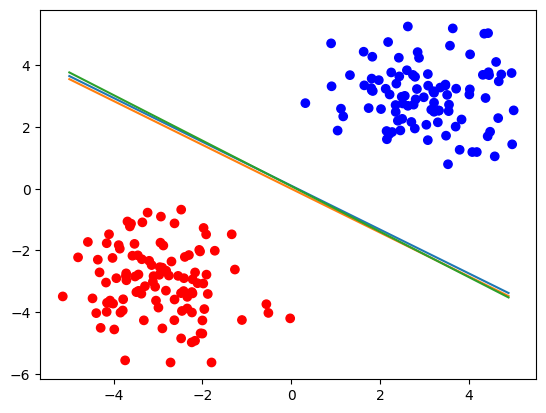

In [43]:
trace_droite(w_sol_scipy)
trace_droite(w_sol_GPD)
trace_droite(w_sol_LV)
_=plt.scatter(X[:, 0], X[:, 1], c=couleur)

## D. Conclusion

Comparer les trois solutions obtenues. D'une part vous visualiserez les 3 droites s√©paratrices correspondantes. Ensuite vous √©valuerez $f$ en ces points. Donner votre avis sur vos r√©sultats.

In [44]:
def valeur_primale(x):
    return 0.5*np.linalg.norm(grad_h(x))

In [45]:
valeur_primale(w_sol_scipy)

np.float64(0.2425333509681456)

In [46]:
valeur_primale(w_sol_GPD)

np.float64(0.2425331649080287)

In [47]:
valeur_primale(w_sol_LV)

np.float64(0.24155915673391679)

# III. Classifier des images

## 1. Obtention des donn√©es : Importer le jeu de donn√©es MNIST

On va r√©soudre un probl√®me similaire, sauf que cette fois les donn√©es ne sont plus des points $x_i \in \mathbb{R}^2$ rouges ou bleus, mais des images $x_i \in \mathbb{R}^{64}$ de chiffres √©crits √† la main.
On ne parlera donc plus de "droite s√©paratrice" mais d'"hyperplan s√©parateur".

| Un nouveau jeu de donn√©es | 
| ----------- |
| ![](images/mnist.jpg) |
| Chaque image de $8\times 8$ pixels est repr√©sent√©e par un point $x_i \in \mathbb{R}^{64}$ |

Pour ce TP on va se contenter de s√©parer des images de 0 et de 1. Leurs √©tiquettes $y_i$ prendront respectivement les valeurs $-1$ et $+1$.



In [48]:
import sklearn.datasets
import sklearn.model_selection

In [49]:
# param√®tres pour l'affichage des images de nombres
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['image.cmap'] = 'gray_r'

In [50]:
# importe les donn√©es
digits = sklearn.datasets.load_digits() # Importe un jeu de donn√©es √† classer (10 classes)
digits.data = digits.data*1/np.max(digits.data) # normalise : coeffs dans [0,1]
classes = [0, 1] # D√©finit les 2 classes de nombres avec lesquelles on va travailler
idx_classes = np.logical_or(digits.target == classes[0], digits.target == classes[1]) # Localise les deux classes ..
digits.data = digits.data[idx_classes] # .. les extrait ..
digits.target = digits.target[idx_classes] # .. et jette le reste
digits.target = np.where(digits.target==classes[0],-1, 1) # Transforme les √©tiquettes de classes en {-1,+1}

X, X_test, Y, Y_test = sklearn.model_selection.train_test_split( # On coupe le jeu de donn√©es en deux
                        digits.data, digits.target, train_size=25, shuffle=True)

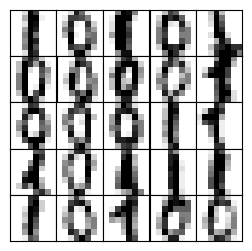

In [51]:
# Affiche les 25 premi√®res images de X
fig, axs = plt.subplots(5, 5, figsize=(3, 3))
for i in range(5):
    for j in range(5):
        k = i*5 + j
        _ = axs[i,j].imshow(X[k].reshape(8,8))
plt.subplots_adjust(wspace=0, hspace=0)

**1)** On dispose de donn√©es `X`, qui contient des images de 0 et 1 √©crits √† la main. Plus pr√©cis√©ment, pour tout `k`, `X[k]` repr√©sente une telle image 2D (8x8 pixels) qui a √©t√© aplatie en un vecteur 1D.

Utiliser `.shape` pour d√©terminer le nombre d'images que contient `X`.

Prendre une image au hasard, et l'afficher avec la fonction `plt.imshow()`. Afin de l'afficher, vous aurez besoin de temporairement remettre cette image sous forme 2D avec la m√©thode `.reshape(nb_lignes, nb_colonnes)` . Est-ce l'image d'un 0 ou d'un 1?

In [52]:
X.shape

(25, 64)

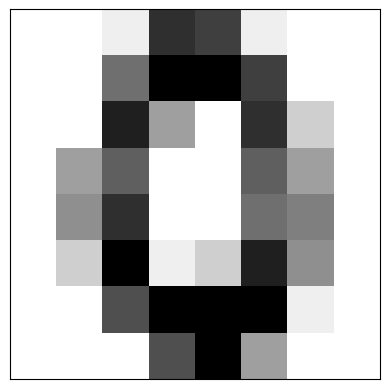

In [53]:
plt.imshow(X[10].reshape(8,8))

**2)** On dispose d'√©tiquettes `Y` qui encodent la nature des images contenues dans `X`. Plus pr√©cis√©ment, `Y[k]` contient `-1` si `X[k]` est l'image d'un 0, ou `+1` si `X[k]` est l'image d'un 1.

Reconsid√©rer l'image affich√©e √† la question pr√©c√©dente, et v√©rifier que son √©tiquette correspond √† ce que vous avez observ√©.

In [54]:
Y[10]

np.int64(-1)

## 2. Phase d'entra√Ænement : Trouver un classifieur avec la m√©thode SVM

**0)** D√©finir `m` le nombre de donn√©es dans notre jeu de donn√©es ; et `n` la taille de chacune de ces donn√©es.

In [55]:
m = X.shape[0]
n = X.shape[1]

**1)** Nous allons trouver un classifieur lin√©aire avec la m√©thode SVM, comme au I.

Pour ce faire, d√©finir deux vecteurs `e`$= (1, \dots , 1)^\top$, `infini`$=(+\infty, \dots, +\infty)^\top$ de $\mathbb{R}^m$, ainsi que la matrice $\Phi \in \mathcal{M}_{m,n+1}(\mathbb{R})$ d√©finie en Section I.2. 

In [56]:
e = np.ones(m)

In [57]:
Phi = np.zeros((m, n+1)) # matrice vide
Phi[:, 0:-1] = X # toutes les colonnes sauf une remplies par X
Phi[:, -1] = e # derni√®re colonne remplie par des 1
Phi = np.diag(Y)@Phi # on multiplie chaque ligne par y_i

In [58]:
infini = e*np.inf

**2)** Adapter √† partir de la Section **II** la m√©thode de r√©solution de votre choix pour obtenir une solution $w=(a,b) \in \mathbb{R}^{n+1}$ du probl√®me de SVM (P). Vous appellerez cette solution `w_mnist`

**Correction: avec scipy**

In [59]:
def objectif(w):
    return np.sum(w**2) - w[-1]**2

In [60]:
C = LinearConstraint(Phi, e, infini)

In [61]:
w_sol_scipy = minimize(fun = objectif, 
               constraints = C,
               x0 = np.zeros(n+1),
              ).x

**Correction: avec Gradient Proximal sur le Dual**

In [62]:
L = np.linalg.norm(Phi,2)**2
mu = np.linalg.norm(Phi,-2)**2
rho = 2/(L+mu)

In [63]:
u_sol_GPD = FB_dual(Phi, Y, rho, nb_iter=10000)

In [64]:
w_sol_GPD = -Phi.T @ u_sol_GPD

**Correction: avec une m√©thode primale-duale**

In [65]:
w_sol_LV, u_sol_LV = LV(Phi, Y, nb_iter=10000)

In [66]:
# on compare que les m√©thodes trouvent les m√™me solutions
# la solution avec GPD √† l'air moins bien
la.norm(w_sol_scipy - w_sol_GPD)

np.float64(0.09728309430513397)

In [67]:
la.norm(w_sol_GPD - w_sol_LV)

np.float64(0.09728302726385747)

In [68]:
la.norm(w_sol_LV - w_sol_scipy)

np.float64(1.8732037869495822e-07)

In [69]:
# dans la suite on en fixe un
w_mnist = w_sol_LV

**3)** Ecrire une fonction `classifieur`, qui:
- prend en entr√©e une image aplatie `x`$\in \mathbb{R}^n$
- prend en entr√©e un vecteur de param√®tres  `w`$=(a,b)\in \mathbb{R}^n \times \mathbb{R}$
- retourne +1 si $\langle a, x \rangle + b \geq 0$, -1 si $\langle a, x \rangle + b \leq 0$

In [70]:
def classifieur(x, w):
    a = w[:-1]
    b = w[-1]
    return np.sign( a.T@x + b )

**4)** Prendre une image au hasard dans `X`, et comparer sa vraie √©tiquette avec la pr√©diction faite par notre nouveau classifieur. Notre pr√©diction est elle bonne?

In [71]:
Y[10]

np.int64(-1)

In [72]:
classifieur(X[10], w_mnist)

np.float64(-1.0)

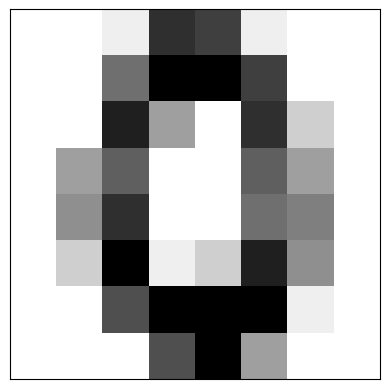

In [73]:
plt.imshow(X[10].reshape(8,8))

## 3. Phase de test : connaitre la vraie performance de notre classifieur

On vient de voir que notre classifieur marche bien lorsque on l'applique aux images contenues dans `X`. Or ceci n'est pas tr√®s surprenant : le classifieur a √©t√© construit √† partir de `w_mnist`, la solution d'un probl√®me d'optimisation d√©pendant des donn√©es contenues dans `X,Y`. Pour vraiment d√©terminer si notre mod√®le a **appris** quelque chose, il faut le tester sur des donn√©es qu'il n'a encore **jamais vues**.

On va donc maintenant utiliser les donn√©es de test `X_test` et `Y_test` que l'on a pas encore utilis√©es.

**1)** Calculer le pourcentage de bonnes r√©ponses donn√©es par notre `classifieur`. Autrement dit, vous allez parcourir l'ensemble des donn√©es de test, et calculer le pourcentage du nombre de fois que le classifieur donne la bonne pr√©diction, en la comparant √† la vraie √©tiquette contenue dans `Y_test`. Que pensez-vous du nombre obtenu?

In [74]:
good = 0
nb_test = X_test.shape[0]
for k in range(nb_test):
    if classifieur(X_test[k], w_mnist) == Y_test[k]:
        good = good + 1
good/nb_test

0.9611940298507463

In [75]:
nb_test

335

**2)** Si le taux de bonne r√©ponse n'est pas de 100%, essayez de trouver dans le jeu de donn√©es quelles sont les images sur lesquelles le classifieur se trompe.

In [76]:
prediction = np.array([classifieur(X_test[k], w_mnist) for k in range(nb_test)])

In [77]:
idx_error = np.where(Y_test != prediction)[0]
idx_error

array([ 36,  42,  74, 121, 191, 195, 210, 211, 218, 227, 228, 282, 332])

In [78]:
n = idx_error[0]
Y_test[n]

np.int64(1)

In [79]:
classifieur(X_test[n,:], w_mnist)

np.float64(-1.0)

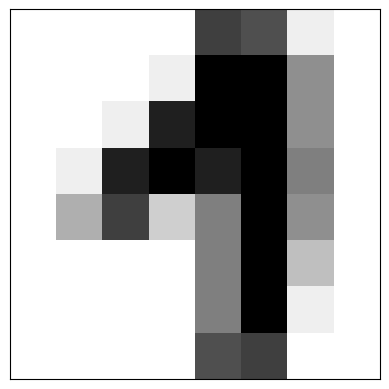

In [80]:
_ = plt.imshow(X_test[n].reshape(8,8))

**3)** Si vous retournez au d√©but de la section **III.**, vous pouvez voir qu'au moment de l'importation nous avons demand√© √† travailler avec les `classes` 0 et 1.

Remplacez ces chiffres par deux autres chiffres de votre choix, et relancez votre code afin de d√©terminer le taux de bonne r√©ponse du classifieur. Essayez de prendre des chiffres difficiles √† classer!

**NB:** Vous ne serez pas not√©s sur cette question, qui vous laisse libre de vous amuser. N√©anmois je vous conseille de ne pas l'ignorer, car vous devrez de toute fa√ßon faire ce genre de choses dans les questions suivantes.

## 4. Aller plus loin : Classification multiple

### a. Discussion

On a vu comment classer des donn√©es √† deux √©tiquettes. Mais en pratique il y a souvent un plus grand nombre de classes : par exemple MNIST peut contenir jusqu'√† 10 classes: les chiffres de 0 √† 9! Un tel classifieur vous est par exemple mis √† disposition sur [ce site](https://mco-mnist-draw-rwpxka3zaa-ue.a.run.app/), qui vous permet de dessiner en ligne un chiffre et vous fournira en temps r√©el une estimation de la probabilit√© d'appartenance √† une classe de chiffre.

Je vous propose dans cette section de construire un tel classifieur. Notre strat√©gie va consister √† r√©unir plusieurs classifieurs √† deux classes (que vous avez appris √† construire dans la section pr√©c√©dente) pour construire un classifieur √† 10 classes. 
Plus pr√©cis√©ment notre strat√©gie sera:

- Couper le jeu de donn√©es en deux classes : les 0 et le reste (1, ..., 9). On produit alors un classifieur qui sera capable de savoir si une image est un z√©ro, ou non.
- On refait la m√™me chose en isolant cette fois 1 versus le reste (0,2, ..., 9). Et ainsi de suite. Ce qui nous donnera 10 classifieurs, chacun r√©pondant √† la question "est-ce que cette image est un 0? un 1? etc.
- Etant donn√© une nouvelle image, on la passe dans les 10 classifieurs, et en fonction des 10 pr√©dictions on prend une d√©cision.




### b. Manipulation des donn√©es et construction du premier classifieur

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.model_selection
from scipy.optimize import LinearConstraint, minimize

In [82]:
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['image.cmap'] = 'gray_r'

In [83]:
digits = sklearn.datasets.load_digits() # Importe un jeu de donn√©es √† classer (10 classes)
digits.data = digits.data*1/np.max(digits.data) # normalise : coeffs dans [0,1]
X, X_test, Y, Y_test = sklearn.model_selection.train_test_split( # On coupe le jeu de donn√©es en deux
                        digits.data, digits.target, train_size=0.25, shuffle=True)
etiquettes_original = Y

**1)** D√©terminer `m` le nombre de donn√©es contenues dans `X`, et `n` la dimension de ces donn√©es.

In [84]:
m = X.shape[0]
n = X.shape[1]

**2)** V√©rifier que `Y` contient bien des √©tiquettes allant de 0 √† 9. Dans le but de classer les 0 vs. le reste, cr√©ez un nouveau vecteur d'√©tiquettes `Y_temp` qui vaut +1 pour les 0, et -1 pour le reste. Faites bien attention √† ne pas modifier le `Y` original!

In [85]:
# 0 vs le reste
cible = 0
Y_temp = np.where(etiquettes_original==cible, 1, -1) # Transforme 'cible' en +1, le reste en -1

**3)** En vous inspirant de ce que vous avez fait √† la section pr√©c√©dente:

- d√©finissez le probl√®me de SVM associ√© au probl√®me de classifier 0 vs. le reste
- r√©solvez-le, afin d'obtenir `w` un vecteur de param√®tres d√©finissant un hyperplan qui s√©pare les 0 des autres chiffres

In [86]:
e = np.ones(m)
infini = e*np.inf

Phi = np.zeros((m, n+1)) # matrice vide
Phi[:, 0:-1] = X # toutes les colonnes sauf une remplies par X
Phi[:, -1] = e # derni√®re colonne remplie par des 1
Phi = np.diag(Y_temp)@Phi # on multiplie chaque ligne par y_i

In [87]:
w, _ = LV(Phi, Y_temp, nb_iter=1000)

**4)** Prenez quelques examples dans `X` et v√©rifiez que `w` d√©finit un hyperplan qui s√©pare bien les 0 du reste (cf. section pr√©c√©dente). Rappelez-vous que les vraies √©tiquettes sont contenues dans `Y`.

In [88]:
a = w[:-1]
b = w[-1]

In [89]:
x = X[12]
Y[12]

np.int64(1)

In [90]:
np.sign(a.T@x + b)

np.float64(-1.0)

### c. Construction d'un classifieur g√©n√©ral

**1)** Ici vous devrez reproduire ce que vous venez de faire :

- Pour chaque chiffre 'cible' entre 0 et 9:
  - D√©finir un vecteur d'√©tiquettes d√©crivant un probl√®me de classification 'cible' vs. le reste
  - D√©finir le probl√®me SVM associ√© et le r√©soudre, ce qui vous donnera un vecteurs de param√®tres w
  - Ranger chacun de ces vecteurs $w \in \mathbb{R}^{n+1}$ comme ligne d'une matrice $W \in \mathcal{M}_{10, n+1}(\mathbb{R})$

In [91]:
W = np.zeros((10, n+1))
for cible in range(10):
    Y_temp = np.where(etiquettes_original==cible, 1, -1) # Transforme 'cible' en +1, le reste en -1
    e = np.ones(m)
    infini = e*np.inf
    Phi = np.zeros((m, n+1)) # matrice vide
    Phi[:, 0:-1] = X # toutes les colonnes sauf une remplies par X
    Phi[:, -1] = e # derni√®re colonne remplie par des 1
    Phi = np.diag(Y_temp)@Phi # on multiplie chaque ligne par y_i
    w, _ = LV(Phi, Y_temp, nb_iter=1000)
    W[cible, :] = w

**2)** V√©rifiez que la matrice `W` obtenue donne de bons r√©sultats. Pour cela, pous pourrez prendre une image quelconque, et la passer dans le classifieur binaire pour chaque ligne de `W` : il devrait renvoyer +1 seulement pour le bon indice.

In [92]:
Y[12]

np.int64(1)

In [93]:
[ classifieur(X[12], W[i,:]) for i in range(10) ]

[np.float64(-1.0),
 np.float64(1.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(-1.0),
 np.float64(-1.0)]

**3)** D√©finir une fonction `classifieur_general` qui:

- prend en entr√©e une donn√©e $x$ et une matrice de param√®tres  $W \in \mathcal{M}_{10, n+1}(\mathbb{R})$
- pour chaque chiffre `i` entre 0 et 9, utilise le classifieur binaire induit par `W[i,:]` pour d√©terminer si $x$ est √©gal √† `i` ou non
- renvoie `i` si $x$ est √©gal √† `i`
- pensez √† faire en sorte que la fonction renvoie toujours quelque chose

Vous testerez sur un exemple que cela marche bien.

In [94]:
def classifieur_general(x, W):
    A = W[:, :-1]
    B = W[:, -1]
    evaluation = A@x + B
    class_vs = np.sign(evaluation) # vecteur de -1 et +1
    return np.argmax(class_vs)

In [95]:
Y[12]

np.int64(1)

In [96]:
classifieur_general(X[12], W)

np.int64(1)

**4)** Appliquez votre `classifieur_general` aux donn√©es de test, comme au **II.3.1)**. Quel est le pourcentage de bonnes r√©ponses de votre classifieur? Que pensez-vous du r√©sultat?

In [97]:
good = 0
nb_test = X_test.shape[0]
for k in range(nb_test):
    if classifieur_general(X_test[k], W) == Y_test[k]:
        good = good + 1
good/nb_test

0.8694362017804155

In [98]:
# est-ce que le classifieur marche bien sur les donn√©es d'entra√Ænement?
good = 0
nb_test = X.shape[0]
for k in range(nb_test):
    if classifieur_general(X[k], W) == Y[k]:
        good = good + 1
good/nb_test

0.9376391982182628

### d. Construction d'un classifieur g√©n√©ral am√©lior√©



Le classifieur pr√©c√©dent souffre de quelques d√©fauts.
Par exemple, si une image est class√©e comme appartenant √† deux classes, comment choisir laquelle des deux est la meilleure?
Et si une image apparait class√©e comme appartenant √† aucune classe, comment choisir quelle classe est la moins mauvaise?
On donc besoin que les classifieurs binaires renvoient un peu plus que une r√©ponse $\pm 1$ pour chaque chiffre : il nous faut √©galement un indice de confiance, une *probabilit√©* que la r√©ponse $\pm 1$ soit correcte.

Par exemple, imaginons que le classifieur biniaire "0 vs. le reste" nous dise que $\mathbb{P}(x=0) = 0.4$. Dans ce cas on pourrait conclure que $x$ n'est pas un 0, puisque $\mathbb{P}(x\neq 0) = 0.6$. Mais si tous les autres classifieurs binaires nous disent √©galement que $\mathbb{P}(x=k) = 0.01$, alors on pourrait se dire que 0 est la moins mauvaise r√©ponse.

Pour notre probl√®me, cette probabilit√© va √™tre li√©e √† la distance entre la donn√©e $x$ et l'hyperplan s√©parateur $H_w$ : plus la donn√©e est proche de l'hyperplan, et moins on aura confiance en la pr√©diction, donc plus basse sera la probabilit√©.

**1)** D√©finir une fonction `classifieur_general2` qui reprend le principe de `classifieur_general`. Cette fois-ci, l'indice `i` renvoy√© sera celui qui maximise la probabilit√© $p_i$, o√π $p \in \mathbb{R}^{10}$ est d√©fini par :

$$ p_i := \frac{e^{v_i}}{\sum\limits_{j=1}^p e^{v_j}},
\quad
v_i := \langle a^i, x \rangle + b^i
$$
avec `W[i,:]`$=(a^i, b^i)$. 
Vous testerez sur un exemple que votre fonction marche bien.

In [99]:
def softmax(v):
    s = np.sum(np.exp(v))
    return np.exp(v)/s

In [100]:
def classifieur_general2(x, W):
    A = W[:, :-1]
    B = W[:, -1]
    evaluation = A@x + B
    confiance = softmax(evaluation)
    etiquette = np.argmax(confiance)
    return etiquette

In [101]:
classifieur_general2(X[12], W)

np.int64(1)

**2)** Estimer la performance de votre nouveau classifieur sur les donn√©es de test. Comparer avec le classifieur pr√©c√©dent. 

In [102]:
good = 0
nb_test = X_test.shape[0]
for k in range(nb_test):
    if classifieur_general2(X_test[k], W) == Y_test[k]:
        good = good + 1
good/nb_test

0.9413946587537092

**Pour aller plus loin:** 

- Rien ne vous emp√™che de dessiner vos propres chiffres, et de tester si votre classifieur le reconnait.. Pour cela il vous suffit de produire une image carr√©e, de la redimensionner en image 8x8, puis de l'importer dans python.
- Il existe d'autres fa√ßons de faire de la classification multiclasse. C'est simplement et rapidement expliqu√© dans [ce cours en ligne](https://openclassrooms.com/fr/courses/4444646-entrainez-un-modele-predictif-lineaire/4507846-classifiez-vos-donnees-en-plus-de-deux-classes) de Chlo√©-Agathe Azencott.

**Notes**

Ressources utilis√©es pour le chargment et utilisation de MNIST:

- https://dmkothari.github.io/Machine-Learning-Projects/SVM_with_MNIST.html
- https://towardsdatascience.com/support-vector-machine-mnist-digit-classification-with-python-including-my-hand-written-digits-83d6eca7004a
- https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

**Avant de partir:** pensez √† bien relire les instructions en d√©but de devoir!